In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
from pandas import Series, DataFrame
sns.set()
%matplotlib inline

# Cleaning the data

## Introduction to the data

In [3]:
off = pd.read_csv('data/OpenFoodFacts.csv', sep='\t', low_memory=False)

This is a dataset of food products listing the ingredients and nutritional facts of more than 1,000,000 foods from over 150 countries in the world.
The data is meant to be free to the public to help users decode food labels, and make better food choices in general.
The dataset contains more than 1,000,000 rows over 175 columns. However, as we will see there are a lot of missing or obviously incorrect values.
- fields that end with _tags are comma-separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutrient (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutrient (in g, or kJ for energy) for 1 serving of the product
- nutrition-score-fr_100g : experimental nutrition score derived from the UK FSA score and adapted for the French market (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition-score-uk_100g : nutrition score defined by the UK Food Standards Administration (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition_grade_fr_100g : Seems to be a simple categorization of the score into A, B, C, D, and E

In [4]:
print('There are {:,} rows '.format(len(off)) + 'and {} columns in our data'.format(off.shape[1]))

There are 1,017,858 rows and 175 columns in our data


In [5]:
off.set_index('code', inplace=True)

## Dealing with missing values

In [6]:
off.isna().sum()

url                         0
creator                     3
created_t                   0
created_datetime            1
last_modified_t             0
                       ...   
choline_100g          1017827
phylloquinone_100g    1017854
beta-glucan_100g      1017838
inositol_100g         1017821
carnitine_100g        1017843
Length: 174, dtype: int64

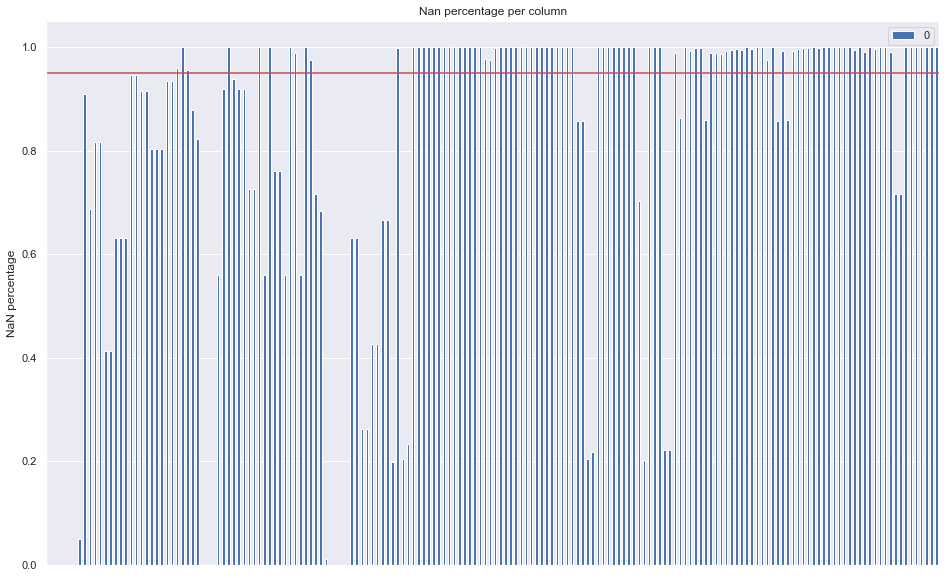

In [7]:
count_nan = off.isna().sum()/len(off)

pl = pd.DataFrame(count_nan).plot(kind="bar", figsize=(16, 10))
plt.xticks([])
pl.set_ylabel("NaN percentage")
pl.set_title("Nan percentage per column")
pl.axhline(y=0.95, color='r', linestyle='-')

We can clearly see that many features have more than 95% of data that is missing. Some columns have up to a 100% of null data.Thus, we decide to drop columns that have more than 95% missing values. 
We still need to have enough values in each column for the analysis to be statistically significant. We calculate the significant sample size (for a confidence level of 99% and a confidence interval of 1, for our population of 1'013'901) by using the following formula : 
$$sample \: size = \dfrac{\dfrac{z^2p(1-p)}{e^2}}{1 + (\dfrac{z^2p(1-p)}{e^2N})} = 16372$$

with z=z_score, e=confidence interval, p=0.5, N=population size, 

5% of the population size is greater than 16372. Thus 95% is a valid threshold for our study.



In [8]:
off = off.dropna(axis=1, thresh= len(off)*0.05, how='all')


In [9]:
print('There are now {:,} rows '.format(len(off)) + 'and {} columns left in our data'.format(off.shape[1]))

There are now 1,017,858 rows and 74 columns left in our data


## Selecting relevant data

We then decide to remove the columns that will not be useufull in our analysis.

In [10]:
off = off.drop(columns=['url',
                        'generic_name',
                        'quantity',
                        'origins_tags',
                        'manufacturing_places_tags',
                        'labels',
                        'emb_codes',
                        'emb_codes_tags',
                        'stores',
                        'traces',
                        'countries_tags',
                          'creator',
                          'created_t',
                          'created_datetime',
                          'last_modified_t',
                          'last_modified_datetime',
                          'brands',
                          'categories',
                          'countries',
                          'serving_size',
                          'serving_quantity',
                          'additives_n',
                          'nova_group',
                          'pnns_groups_1',
                          'states',
                          'main_category',
                          'image_url',
                          'image_small_url',
                          'image_ingredients_url',
                          'image_ingredients_small_url',
                          'image_nutrition_url',
                          'image_nutrition_small_url'
                         ])

In [11]:
print('There are now {:,} rows '.format(len(off)) + 'and {} columns left in our data'.format(off.shape[1]))

There are now 1,017,858 rows and 42 columns left in our data


We check for any duplicates and delete them.

In [12]:
print(off.duplicated().sum())
off.drop_duplicates(inplace=True)
print(off.duplicated().sum())

60846
0


In [13]:
off.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,444753.000000,444753.00000,8.020110e+05,7.972800e+05,7.683310e+05,142041.000000,142884.000000,797229.000000,7.835790e+05,2.995740e+05,7.991770e+05,7.794000e+05,7.793490e+05,137038.000000,140575.000000,144057.000000,140664.000000,284209.000000,284209.000000
mean,0.027447,0.07220,8.311057e+36,2.500431e+01,1.113884e+01,0.074208,0.028594,30.057896,2.011333e+01,1.767649e+02,1.195129e+02,1.064994e+02,4.279684e+01,0.002389,0.022753,0.216139,0.006940,9.222248,8.968991
std,0.165324,0.31739,7.442972e+39,9.800429e+03,5.121082e+03,1.504284,0.908712,965.568835,5.168370e+03,9.301643e+04,9.934212e+04,9.162384e+04,3.665118e+04,0.369428,0.734446,6.602784,0.338523,8.813142,9.268075
min,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,-3.570000,0.000000,0.000000,-1.786000e+01,-2.000000e+01,-8.000000e+02,0.000000e+00,0.000000e+00,-0.000340,-0.002100,0.000000,-0.000260,-15.000000,-15.000000
25%,0.000000,0.00000,4.270000e+02,6.000000e-01,1.000000e-01,0.000000,0.000000,3.640000,8.000000e-01,0.000000e+00,1.180000e+00,6.000000e-02,2.000000e-02,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,0.000000,0.00000,1.096000e+03,6.750000e+00,1.900000e+00,0.000000,0.000000,15.800000,4.000000e+00,1.600000e+00,5.700000e+00,5.156200e-01,2.000000e-01,0.000000,0.000000,0.036000,0.001050,10.000000,8.000000
75%,0.000000,0.00000,1.674000e+03,2.120000e+01,7.300000e+00,0.000000,0.020000,54.000000,2.000000e+01,3.600000e+00,1.180000e+01,1.330000e+00,5.200000e-01,0.000107,0.004000,0.115000,0.002480,16.000000,17.000000
max,3.000000,6.00000,6.665559e+42,8.748748e+06,4.488758e+06,369.000000,141.000000,857855.000000,4.574988e+06,5.089889e+07,8.880858e+07,8.088869e+07,3.235548e+07,100.000000,100.000000,950.000000,50.000000,40.000000,40.000000


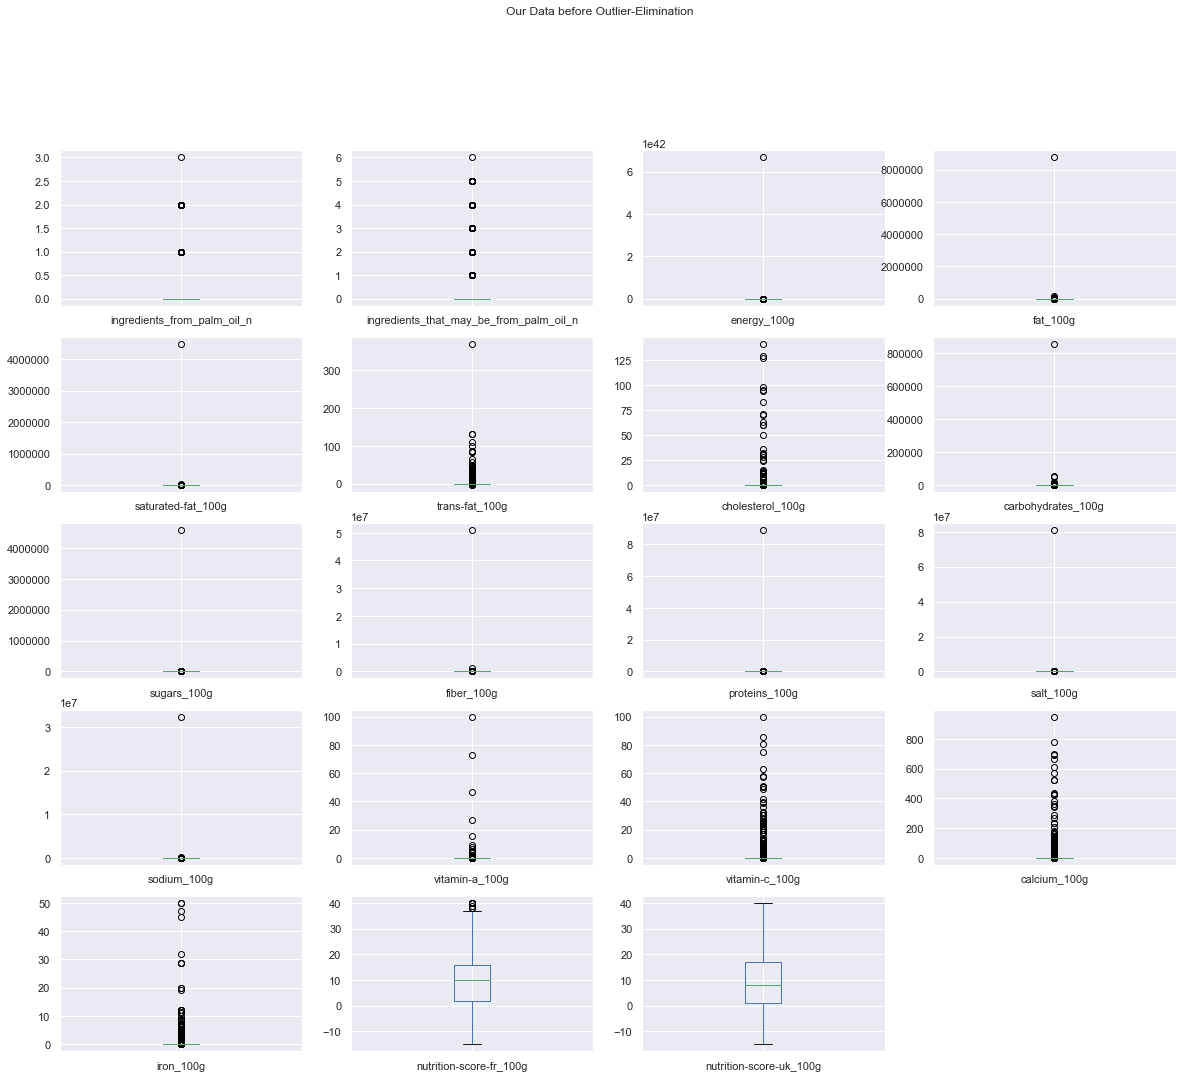

In [14]:
off.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(20,20), layout=(6,4)) 
plt.show()

We can see that almost all the features contains some outliers. We need to deal with those before moving on. We will start by remove values that are not possible: a negative amount of energy or negative amount of nutrient in a product.

In [15]:
#we want to remove any impossible values, for example for any value that is supposed to be between 0g and 100g. We decide to keep the nan,
# because we might need these rows later.
off = off[ ((off['trans-fat_100g'] >= 0) & (off['trans-fat_100g'] <= 100) )| (off['trans-fat_100g'].isnull())]
off = off[ ((off['sugars_100g'] >= 0) & (off['sugars_100g'] <= 100) )| (off['sugars_100g'].isnull()) ]
off = off[ ((off['fiber_100g'] >= 0) & (off['fiber_100g'] <= 100) )| (off['fiber_100g'].isnull())]
off = off[ ((off['proteins_100g'] >= 0) & (off['proteins_100g'] <= 100) )| (off['proteins_100g'].isnull())]
off = off[ ((off['vitamin-a_100g'] >= 0) & (off['vitamin-a_100g'] <= 100) )| (off['vitamin-a_100g'].isnull())]
off = off[ ((off['vitamin-c_100g'] >= 0 ) & (off['vitamin-c_100g'] <= 100))| (off['vitamin-c_100g'].isnull())]
off = off[ ((off['iron_100g'] >= 0) & (off['iron_100g'] <= 100) )| (off['iron_100g'].isnull())]
off = off[ ((off['energy_100g'] >= 0) & (off['energy_100g'] <= 1500))| (off['energy_100g'].isnull())]
off = off[ ((off['fat_100g'] >= 0) & (off['fat_100g'] <= 100) )| (off['fat_100g'].isnull())]
off = off[ ((off['saturated-fat_100g'] >= 0) & (off['saturated-fat_100g'] <= 100) )| (off['saturated-fat_100g'].isnull())]
off = off[ ((off['cholesterol_100g'] >= 0) & (off['cholesterol_100g'] <= 100) )| (off['cholesterol_100g'].isnull())]
off = off[ ((off['carbohydrates_100g'] >= 0) & (off['carbohydrates_100g'] <= 100) )| (off['carbohydrates_100g'].isnull())]
off = off[ ((off['salt_100g'] >= 0) & (off['salt_100g'] <= 100) )| (off['salt_100g'].isnull())]
off = off[ ((off['sodium_100g'] >= 0) & (off['sodium_100g'] <= 100) )| (off['sodium_100g'].isnull())]
off = off[ ((off['calcium_100g'] >= 0) & (off['calcium_100g'] <= 100) )| (off['calcium_100g'].isnull())]
off.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,304218.000000,304218.000000,527739.000000,524488.000000,499137.000000,86728.000000,87483.000000,524718.000000,514779.000000,191323.000000,525801.000000,511824.000000,511790.000000,85312.000000,89338.000000,91064.000000,86821.000000,189839.000000,189839.000000
mean,0.012337,0.064385,677.909790,6.277114,2.562663,0.039341,0.023699,19.935927,9.882998,2.247118,7.060859,1.600456,0.635789,0.002894,0.028869,0.106946,0.004134,5.963495,5.238771
std,0.111568,0.301107,465.978757,8.477251,4.336762,0.901621,0.478776,23.694618,16.637903,4.965178,8.499898,6.367132,2.540091,0.430598,0.821453,1.227938,0.263301,7.313264,7.535931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,247.000000,0.100000,0.000000,0.000000,0.000000,2.800000,0.600000,0.000000,0.600000,0.045720,0.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,619.000000,2.400000,0.640000,0.000000,0.000000,10.300000,3.000000,1.000000,3.700000,0.508000,0.200000,0.000021,0.000000,0.033000,0.000600,4.000000,3.000000
75%,0.000000,0.000000,1079.000000,9.800000,3.000000,0.000000,0.026000,27.900000,10.900000,2.500000,11.000000,1.391920,0.548000,0.000125,0.006700,0.106000,0.001480,12.000000,12.000000
max,3.000000,5.000000,1500.000000,100.000000,100.000000,100.000000,70.588000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,50.000000,40.000000,38.000000


In [16]:
# here we remove the outliers, we use the calculation of the 99th quantile . any value being greater than the 99th quantile is rejected,
# we do not use the negative 99th quantile as the previous step already remove the negative values.
# for the same reason we keep the outliers
off = off[ (np.abs(off['energy_100g']-off['energy_100g'].mean())<=(3*off['energy_100g'].std())) | off['energy_100g'].isnull()]
off = off[ (np.abs(off['fat_100g']-off['fat_100g'].mean())<=(3*off['fat_100g'].std())) | off['fat_100g'].isnull()]
off = off[ (np.abs(off['saturated-fat_100g']-off['saturated-fat_100g'].mean())<=(3*off['saturated-fat_100g'].std())) | off['saturated-fat_100g'].isnull()]
off = off[ (np.abs(off['trans-fat_100g']-off['trans-fat_100g'].mean())<=(3*off['trans-fat_100g'].std())) | off['trans-fat_100g'].isnull()]
off = off[ (np.abs(off['cholesterol_100g']-off['cholesterol_100g'].mean())<=(3*off['cholesterol_100g'].std())) | off['cholesterol_100g'].isnull()]
off = off[ (np.abs(off['carbohydrates_100g']-off['carbohydrates_100g'].mean())<=(3*off['carbohydrates_100g'].std())) | off['carbohydrates_100g'].isnull()]
off = off[ (np.abs(off['sugars_100g']-off['sugars_100g'].mean())<=(3*off['sugars_100g'].std())) | off['sugars_100g'].isnull()]
off = off[ (np.abs(off['fiber_100g']-off['fiber_100g'].mean())<=(3*off['fiber_100g'].std())) | off['fiber_100g'].isnull()]
off = off[ (np.abs(off['proteins_100g']-off['proteins_100g'].mean())<=(3*off['proteins_100g'].std())) | off['proteins_100g'].isnull()]
off = off[ (np.abs(off['salt_100g']-off['salt_100g'].mean())<=(3*off['salt_100g'].std())) | off['salt_100g'].isnull()]
off = off[ (np.abs(off['sodium_100g']-off['sodium_100g'].mean())<=(3*off['sodium_100g'].std())) | off['sodium_100g'].isnull()]
off = off[ (np.abs(off['vitamin-a_100g']-off['vitamin-a_100g'].mean())<=(3*off['vitamin-a_100g'].std())) | off['vitamin-a_100g'].isnull()]
off = off[ (np.abs(off['vitamin-c_100g']-off['vitamin-c_100g'].mean())<=(3*off['vitamin-c_100g'].std())) | off['vitamin-c_100g'].isnull()]
off = off[ (np.abs(off['calcium_100g']-off['calcium_100g'].mean())<=(3*off['calcium_100g'].std())) | off['calcium_100g'].isnull()]
off = off[ (np.abs(off['iron_100g']-off['iron_100g'].mean())<=(3*off['iron_100g'].std())) | off['iron_100g'].isnull()]
off.describe()


,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,271425.000000,271425.000000,466947.000000,463808.000000,443285.000000,77207.000000,78027.000000,464097.000000,456145.000000,171466.000000,465083.000000,452353.000000,452321.000000,76221.000000,80118.000000,81523.000000,77650.000000,171676.000000,171676.000000
mean,0.012383,0.067757,626.070100,5.599118,2.048000,0.014002,0.017830,17.996025,7.841222,1.778180,6.558957,0.837759,0.332117,0.000166,0.009392,0.071213,0.001187,5.273661,4.349967
std,0.111846,0.309923,443.015484,7.060302,3.023921,0.135616,0.036534,21.019840,12.020084,2.440208,7.214222,1.081054,0.429275,0.001152,0.046105,0.126026,0.003488,7.064514,7.012638
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,226.000000,0.200000,0.000000,0.000000,0.000000,3.000000,0.600000,0.000000,0.700000,0.043180,0.015240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,548.000000,2.400000,0.600000,0.000000,0.000000,10.000000,3.000000,1.000000,3.600000,0.487680,0.184912,0.000026,0.000000,0.032000,0.000610,4.000000,2.000000
75%,0.000000,0.000000,992.000000,9.000000,2.700000,0.000000,0.025000,24.650000,10.000000,2.400000,10.300000,1.250000,0.493776,0.000120,0.007100,0.100000,0.001410,11.000000,10.000000
max,3.000000,5.000000,1500.000000,31.700000,14.600000,2.700000,1.081000,92.110000,59.650000,17.000000,32.100000,19.800000,2.688000,0.135420,2.400000,3.200000,0.580000,38.000000,38.000000


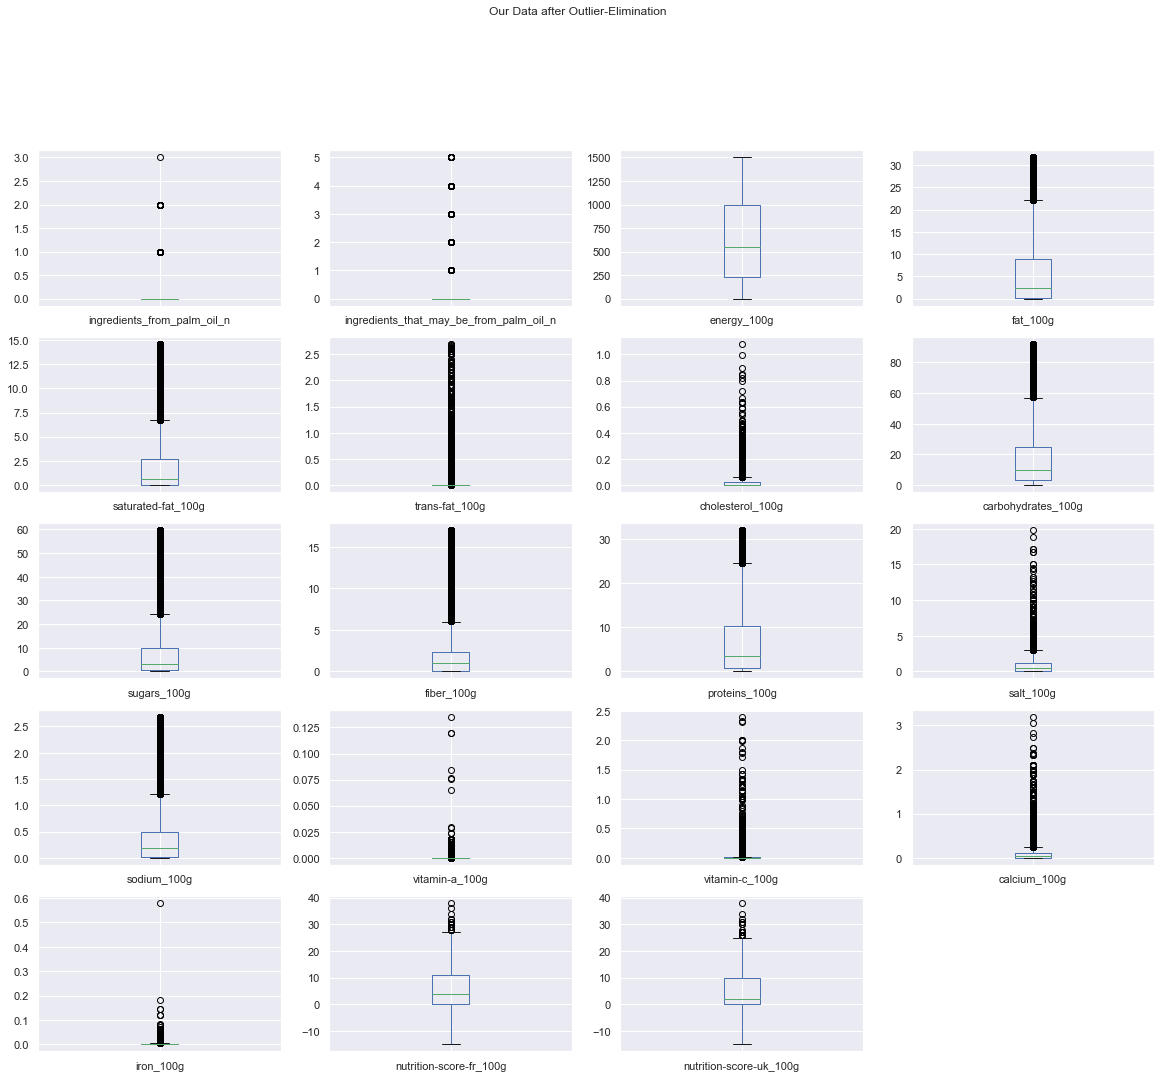

In [17]:
off.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination', figsize=(20,20), layout=(6,4)) 
plt.show()

Here are the new boxplots. We cans still see outliers on the plots but, there is no data that is impossible. All the numbers that should be under 100g is under 100g etc. thus our data is plausible. In adition if we take a look at the stats shown previously, the mean, max and min are completely fine.

In [18]:
print(len(off))

621528


At this point, we have two options. Do we:   
a) Filter out the rows that contain NaNs in the columns above, and end up with a dataframe of ~100'000 products, but with rows full of data, and conduct all our analysis on it? Or  
b) keep the rows with the NaNs, so we keep our dataframe with ~600'000 products, but alot of missing values, and for each question we treat, we create a new dataframe with only the relevant columns and remove rows with NaNs then?   
We went with the later method, so we would have more data to analyze for each individual question, but it means we would be working on different subsamples of the big dataframe at each step.

## Cleaning countries_en

In [19]:
off['countries_en'].dropna().unique().shape[0]

1555

We can clearly see that the data is not clean. Finding 1552 unique countries is impossible. 



In [20]:
off['countries_en'].unique()

array(['France', 'Ireland', nan, ...,
       'Australia,Belgium,France,United Kingdom,United States',
       'Australia,Belgium,France,Japan,New Zealand,United Kingdom,United States',
       'Australia,Belgium,France,Japan,New Zealand,United Kingdom'],
      dtype=object)

After taking a closer look at the data we can see that some countries are 'nan' and other are list of countries, thus we are gonna explode the data.

In [21]:
off_countries_exploded = off

In [22]:
off_countries_exploded['countries_en'] = off_countries_exploded['countries_en'].apply(lambda x: str(x).split(','))

In [23]:
off_countries_exploded = off_countries_exploded.explode('countries_en')
off_countries_exploded['countries_en'].unique()

array(['France', 'Ireland', 'nan', 'Belgium', 'United States',
       'United Kingdom', 'Spain', 'Canada', 'Portugal', 'Switzerland',
       'Peru', 'Slovenia', 'Germany', 'Netherlands', 'Kuwait', 'Italy',
       'Australia', 'Israel', 'Mexico', 'Guadeloupe', 'Chile', 'Greece',
       'Russia', 'India', 'Luxembourg', 'Réunion', 'Dominican Republic',
       'Singapore', 'Austria', 'United Arab Emirates', 'Sweden', 'Gabon',
       'Pakistan', 'French Polynesia', 'Egypt', 'Palestinian territories',
       'Taiwan', 'Morocco', 'Brazil', 'En', 'Guatemala', 'Saudi Arabia',
       'Iraq', 'Romania', 'Panama', 'Colombia', 'Moldova',
       'Czech Republic', 'New Caledonia', 'Finland', 'Niger', 'Vietnam',
       'Qatar', 'New Zealand', 'Thailand', 'China', 'Saint Lucia',
       'Puerto Rico', 'Lebanon', 'Costa Rica', 'Malaysia',
       'Trinidad and Tobago', 'Jordan', 'Honduras', 'Tunisia', 'Jamaica',
       'Hong Kong', 'Mauritius', 'Saint Martin', 'Republic of Macedonia',
       'Rwanda', 'Ja

We can see that many countries have still a weird syntax or do not exist. We download a list of all countries in the world and join it.

In [24]:
off_countries_exploded['countries_en'].value_counts().tail(50)

Faroe Islands                          2
Montserrat                             2
fr:belgia                              2
es:espanya                             1
ar:ومصر-والأردن                        1
Comoros                                1
Ed-kingdom                             1
de:slovénie                            1
D-e-1-d91-j-de                         1
Belize                                 1
Xk                                     1
fr:ffgvg                               1
Antigua and Barbuda                    1
Lesotho                                1
Ruoŧŧa                                 1
fr:angleterre                          1
Anguilla                               1
Timor-Leste                            1
de:en                                  1
fr:u-s-a-et-mexique                    1
ja:茨城県                                 1
Equatorial Guinea                      1
Guernsey                               1
fr:export                              1
Åland Islands   

We can see that most of the countries that have special/wrong names are used just a few times in the data set

In [25]:
# in order to select only the countries that are existing countries a that are well written, we load from the web a list of all
#countries in the world. The next step will be to keep only the countries that are in the list.
f = open('data/country-keyword-list.txt', 'r',encoding="utf16")
list_of_countries  = [line.strip() for line in f]

In [26]:
off_countries_exploded = off_countries_exploded[off_countries_exploded['countries_en'].apply(lambda x: x in list_of_countries)]

In [27]:
off_countries_exploded['countries_en'].unique().shape[0]

157

We now have 157 unique countries left and more than 650,000 lines in our data set.

# Exploring the data

In [58]:
%%capture
!pip install geopandas
import geopandas as gpd

In [29]:
#Read shapefile using Geopandas
gdf = gpd.read_file('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [30]:
#Renaming United States of America
gdf.loc[4, 'country'] = 'United States'
#Drop row corresponding to 'Antarctica'
print(gdf[gdf['country'] == 'Antarctica'])
gdf = gdf.drop(gdf.index[159])

        country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


In [31]:
#making dataframe of country count percentges
country_counts_std = (((off_countries_exploded['countries_en'].value_counts())/len(off_countries_exploded))*100).to_frame('counts')
country_counts_std['country'] = country_counts_std.index
country_counts_std

,counts,country
France,57.509659,France
United States,15.350037,United States
Spain,7.576316,Spain
Germany,3.968935,Germany
Switzerland,3.814459,Switzerland
...,...,...
Lesotho,0.000151,Lesotho
Tajikistan,0.000151,Tajikistan
England,0.000151,England
Liberia,0.000151,Liberia


In [32]:
#merged = gdf.merge(country_counts_std, left_on = 'country', right_on = 'country')
merged = gdf.merge(country_counts_std, on = 'country', how = 'left')
#Replace NaN values to string 'No data'.
merged.fillna({'counts' : 'No data'}, inplace = True)
merged

,country,country_code,geometry,counts
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.000302303
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",No data
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",No data
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.615791
4,United States,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",15.35
...,...,...,...,...
171,Republic of Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",No data
172,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.00544145
173,Kosovo,KOS,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0.00302303
174,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",No data


In [33]:
import json
#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [34]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40, nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Percentage of products sold across countries', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'counts', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

**NB : If the map does not show, please refer to the screenshot in the repository.**

We can see here the dominance of France in the dataset, as more than 50% of the data comes from France. Thus we will have to consider this bias in our future analysis. However we still have relevant country wise data for countries such as the USA or even Spain and Switzerland. They still are representative of their own population, considering the size of the dataset.


##Question 1: To what extent does this database represent the global food consumption
The Amount of data coming from France and the USA represent almost 3/4 of the  whole dataset. Therefore we cannot say that the dataset gives a good representation of worldwide food consumption. In addition some countries are not even represented.

Threfore, we decided to focus our questions on the two most represented countries: France and the USA. Each question that we planned on answering on a world scale will rather be treated as a comparison between these two countries.

Based on this last analysis, we can more accurately see where we are headed. 
What we intended to analyse globally will now be a comparison between France and USA, but this remains an interesting study.  
Our study will focus on the food trends in these countries (and the others that still have enough data), including nutrition facts and chronology.
Ecology still remains a vast subject that we can tackle thanks to this reshaping of the data.
Studies on soda, alcohol and other characteristic products also remain in sight.

# Food characteristics USA vs. France

In [35]:
off_countries_exploded = off_countries_exploded[(off_countries_exploded['countries_en']=='United States')|
                                        (off_countries_exploded['countries_en']=='France')]

In [36]:
countries_grouped = off_countries_exploded.groupby('countries_en')

In [37]:
countries_grouped.describe()

ingredients_from_palm_oil_n                                     \
                                    count      mean       std  min  25%  50%   
countries_en                                                                   
France                           132538.0  0.020017  0.141665  0.0  0.0  0.0   
United States                     97019.0  0.000031  0.005561  0.0  0.0  0.0   

                        ingredients_that_may_be_from_palm_oil_n            \
               75%  max                                   count      mean   
countries_en                                                                
France         0.0  3.0                                132538.0  0.097708   
United States  0.0  1.0                                 97019.0  0.031695   

               ... nutrition-score-fr_100g       nutrition-score-uk_100g  \
               ...                     75%   max                   count   
countries_en   ...                                                         
France         ...                    12.0  38.0                123462.0   
United States  ...                    10.0  25.0                 13531.0   

                                                               
                   mean       std   min  25%  50%   75%   max  
countries_en                                                   
France         4.714098  7.046926 -15.0  0.0  3.0  11.0  38.0  
United States  3.360210  7.518975 -14.0 -2.0  2.0   9.0  25.0  

[2 rows x 152 columns]

In [38]:
country_fat = countries_grouped['fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_fat

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
France,282351.0,5.987883,7.215234,0.0,0.5,2.90,9.70,31.7
United States,97547.0,4.598981,6.735010,0.0,0.0,1.16,7.14,31.7


In [39]:
country_sugar = countries_grouped['sugars_100g'].describe().sort_values(by='mean',ascending=False)
country_sugar

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,91813.0,9.387218,12.306174,0.0,1.18,4.38,12.39,59.65
France,283039.0,7.655536,12.261041,0.0,0.60,2.50,9.70,59.60


In [40]:
country_salt = countries_grouped['salt_100g'].describe().sort_values(by='mean',ascending=False)
country_salt

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,96596.0,0.861514,1.108346,0.0,0.0381,0.47752,1.27,14.4
France,274570.0,0.845894,1.084619,0.0,0.0400,0.50000,1.27,18.9


In [41]:
country_healthy_fr = countries_grouped['nutrition-score-fr_100g'].describe().sort_values(by='mean',ascending=True)
country_healthy_fr

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,13531.0,3.812800,7.586129,-14.0,-2.0,2.0,10.0,25.0
France,123462.0,5.753268,7.066913,-15.0,0.0,4.0,12.0,38.0


In [42]:
country_healthy_uk = countries_grouped['nutrition-score-uk_100g'].describe().sort_values(by='mean',ascending=True)
country_healthy_uk

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,13531.0,3.360210,7.518975,-14.0,-2.0,2.0,9.0,25.0
France,123462.0,4.714098,7.046926,-15.0,0.0,3.0,11.0,38.0


In [43]:
country_palm = countries_grouped['ingredients_that_may_be_from_palm_oil_n'].describe().sort_values(by='mean',ascending=True)
country_palm

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,97019.0,0.031695,0.178740,0.0,0.0,0.0,0.0,3.0
France,132538.0,0.097708,0.381411,0.0,0.0,0.0,0.0,5.0


In [44]:
country_trans_fat = countries_grouped['trans-fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_trans_fat

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
France,791.0,0.023953,0.109633,0.0,0.0,0.0,0.0,1.78
United States,76506.0,0.013377,0.134400,0.0,0.0,0.0,0.0,2.70


In [45]:
country_saturated_fat = countries_grouped['saturated-fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_saturated_fat

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
France,282766.0,2.117014,3.027148,0.0,0.1,0.7,2.80,14.60
United States,79931.0,1.947349,3.186756,0.0,0.0,0.0,2.78,14.58


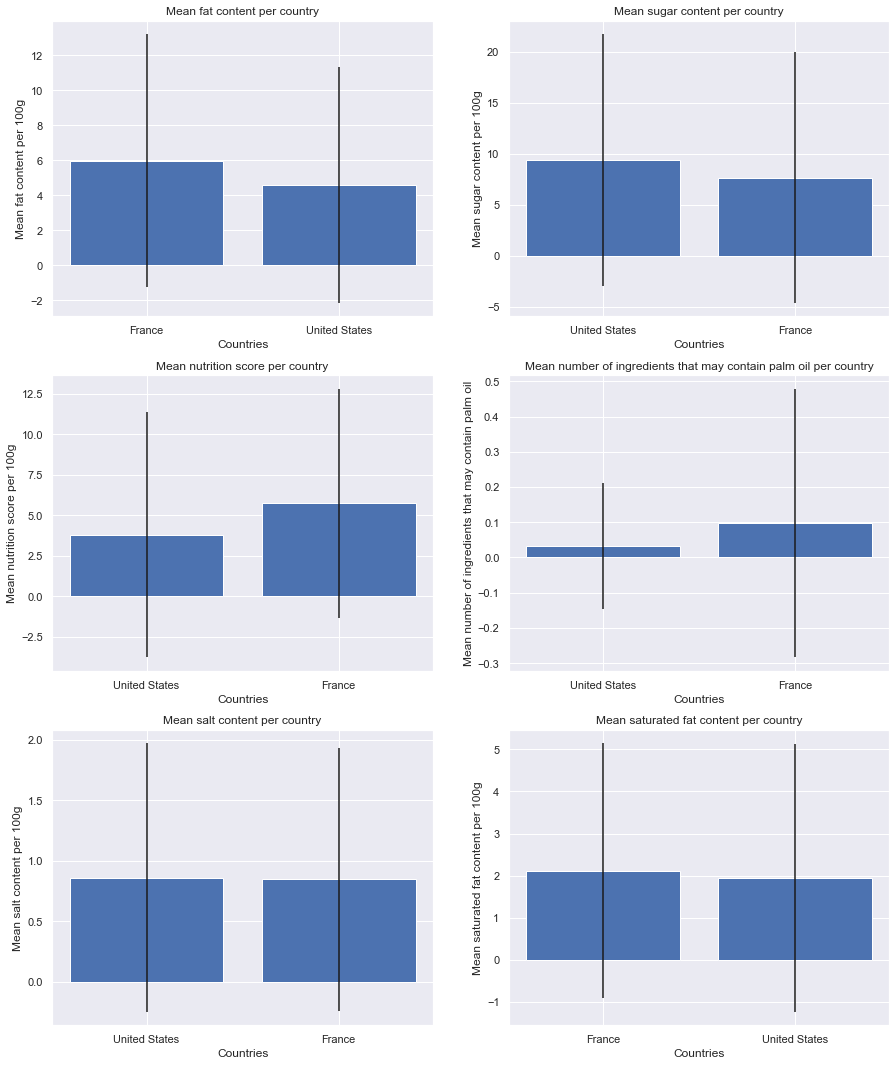

In [46]:
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(15)

plt.subplot(4,2,1)
index_fat = country_fat.index
mean_fat = country_fat['mean'] 
std_fat = country_fat['std']

x_pos_fat = [i for i, _ in enumerate(index_fat)]
plt.bar(x_pos_fat, mean_fat, yerr=std_fat)
plt.xlabel("Countries")
plt.ylabel("Mean fat content per 100g")
plt.title("Mean fat content per country")
plt.xticks(x_pos_fat, index_fat)


plt.subplot(4,2,2)
index_sugar = country_sugar.index
mean_sugar = country_sugar['mean'] 
std_sugar = country_sugar['std']

x_pos_sugar = [i for i, _ in enumerate(index_sugar)]
plt.bar(x_pos_sugar, mean_sugar, yerr=std_sugar)
plt.xlabel("Countries")
plt.ylabel("Mean sugar content per 100g")
plt.title("Mean sugar content per country")
plt.xticks(x_pos_sugar, index_sugar)

plt.subplot(4,2,3)
index_healthy_fr = country_healthy_fr.index
mean_healthy_fr = country_healthy_fr['mean'] 
std_healthy_fr = country_healthy_fr['std']

x_pos_healthy_fr = [i for i, _ in enumerate(index_healthy_fr)]
plt.bar(x_pos_healthy_fr, mean_healthy_fr, yerr=std_healthy_fr)
plt.xlabel("Countries")
plt.ylabel("Mean nutrition score per 100g")
plt.title("Mean nutrition score per country")
plt.xticks(x_pos_healthy_fr, index_healthy_fr)

plt.subplot(4,2,4)
index_palm = country_palm.index
mean_palm = country_palm['mean'] 
std_palm = country_palm['std']

x_pos_palm = [i for i, _ in enumerate(index_palm)]
plt.bar(x_pos_palm, mean_palm, yerr=std_palm)
plt.xlabel("Countries")
plt.ylabel("Mean number of ingredients that may contain palm oil")
plt.title("Mean number of ingredients that may contain palm oil per country")
plt.xticks(x_pos_palm, index_palm)

#plt.subplot(4,2,5)
#index_trans_fat = country_trans_fat.index
#mean_trans_fat = country_trans_fat['mean'] 
#std_trans_fat = country_trans_fat['std']
#
#x_pos_trans_fat = [i for i, _ in enumerate(index_trans_fat)]
#plt.bar(x_pos_trans_fat, mean_trans_fat, yerr=std_trans_fat)
#plt.xlabel("Countries")
#plt.ylabel("Mean trans fat content per 100g")
#plt.title("Mean trans fat content per country")
#plt.xticks(x_pos_fat, index_fat)

plt.subplot(4,2,6)
index_saturated_fat = country_saturated_fat.index
mean_saturated_fat = country_saturated_fat['mean'] 
std_saturated_fat = country_saturated_fat['std']

x_pos_saturated_fat = [i for i, _ in enumerate(index_saturated_fat)]
plt.bar(x_pos_saturated_fat, mean_saturated_fat, yerr=std_saturated_fat)
plt.xlabel("Countries")
plt.ylabel("Mean saturated fat content per 100g")
plt.title("Mean saturated fat content per country")
plt.xticks(x_pos_fat, index_fat)

plt.subplot(4,2,5)
index_salt = country_salt.index
mean_salt = country_salt['mean'] 
std_salt = country_salt['std']

x_pos_salt = [i for i, _ in enumerate(index_salt)]
plt.bar(x_pos_salt, mean_salt, yerr=std_salt)
plt.xlabel("Countries")
plt.ylabel("Mean salt content per 100g")
plt.title("Mean salt content per country")
plt.xticks(x_pos_salt, index_salt)


plt.show()

In [49]:
#fig = plt.figure()
#fig.set_figheight(7)
#fig.set_figwidth(15)
#
#plt.subplot(1,2,1)
#france_trans_percentage = (country_trans_fat['count']['France']/country_fat['count']['France'])*100
#labels = 'trans fats', ''
#sizes = [france_trans_percentage, 100 - france_trans_percentage]
#colors = ['lightcoral', 'gold']
#
#plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
#plt.axis('equal')
#plt.title("Percentage of products that contain trans fats \n from total products that contain fat in France")
#
#plt.subplot(1,2,2)
#US_trans_percentage = (country_trans_fat['count']['United States']/country_fat['count']['United States'])*100
#labels = 'trans fats', ''
#sizes = [US_trans_percentage, 100 - US_trans_percentage]
#colors = ['lightcoral', 'gold']
#
#plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
#plt.axis('equal')
#plt.title("Percentage of products that contain trans fats \n from total products that contain fat in the United States")
#
#plt.show()

We often stigmatize the american diet by saying that it is unhealthy compared to the rest of the world. So we decided to look into the nutrition facts of the products sold in the United States compared to France to see whether this stigma is confirmed by data. We look at the difference in mean content of nutrients commonly known as 'unhealthy' (fat, sugar, sodium, palm oil, trans fat, saturated fat) in products sold in the US opposed to France. 

The results we obtained (Figure ) go back and forth between the two countries, and do not point to a particular country diet as being healthier.
We can see that French products have a higher mean fat content, whereas American products contain more sugar. French products also contain more ingredients that may contain palm oil. The nutritional score is higher (worse) in French prodcuts due to the fact that this value is highly correlated with fat. No significant difference is observed in saturated fat and salt content. Trans fats turned out not to be an interesting statistic to look at because not enough French products had data for this field.
Not much can be concluded from these results, we cannot say that one country is healthier than the other. Furthermore, this dataset is not very indicative of a country's diet as it does not represent consumption behaviour, but only a range of available products. Healthy and unhealthy products are found in every country, and this is not what determines the country's diet. The diet is rather determined by the consumption behaviour and habits of the country's population : Which products do they buy? How many times do they eat out on average? Do they opt for healthy meals or fast food when they do eat out?